## Look at the Data


In [11]:
# Import necesaary libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
import cvxpy as cp
import time

# Ensure reproducability
np.random.seed(0)

In [12]:
# Load the .mat file
data = loadmat("Data/mimo_detection.mat")

# Look at data
for  key, item in data.items():
    if type(item) != np.ndarray:
        print(f"{key}: {item}")
    else:
        print(f"{key}: shape {np.shape(item)}")
        print(f" Complex: {item.dtype.kind == 'c'}")
print("\n")

# Extract variables
Nrx = data['Nrx'][0][0]   # Number of receive antennas
print(f'Number of receive antennas: {Nrx}')
Ntx = data['Ntx'][0][0]  # Number of transmit antennas
print(f'Number of transmit antennas: {Ntx}')
SNR = data['snrdB'][0][0]
print(f'SNR: {SNR} dB')
Sc = data['sc']  # Transmitted symbols
Hc = data['Hc']  # Channel matrix
Yc = data['yc']  # Received symbols


__header__: b'MATLAB 5.0 MAT-file, Platform: MACI64, Created on: Thu Dec  1 07:49:52 2016'
__version__: 1.0
__globals__: []
Hc: shape (40, 40)
 Complex: True
Nrx: shape (1, 1)
 Complex: False
Ntx: shape (1, 1)
 Complex: False
sc: shape (40, 1)
 Complex: True
snrdB: shape (1, 1)
 Complex: False
yc: shape (40, 1)
 Complex: True


Number of receive antennas: 40
Number of transmit antennas: 40
SNR: 20 dB


## Convert to appropriate form for optimization

In [ ]:
# Create function to convert complex to real-valued representation
def complex_to_real(Hc, Yc, Sc):
    # Vectors can be (M,1) or (M,)
    yc = np.asarray(Yc).reshape(-1)
    sc = np.asarray(Sc).reshape(-1)

    H = np.block([
        [Hc.real, -Hc.imag],
        [Hc.imag,  Hc.real]
    ])
    y = np.concatenate([yc.real, yc.imag], axis=0)
    s = np.concatenate([sc.real, sc.imag], axis=0)
    return H, y, s

# Convert to real-valued representation
H, y, s_labels = complex_to_real(Hc, Yc, Sc)

# Make the matrices for the QP formulation
HtH = H.T @ H                      
Hty = (H.T @ y).reshape(-1, 1)    
yty = np.array([[y @ y]])         

A = np.block([
    [HtH,        -Hty],
    [-Hty.T,      yty]
])

Real-valued H shape: (80, 80), y shape: (80,), s_labels shape: (80,)


## Optimize using CVXPy Library

In [18]:
# Parameters
N = 2 * Ntx + 1

# Define and solve the SDP relaxation
X = cp.Variable((N, N), PSD=True)
constraints = [cp.diag(X) == 1]
objective = cp.Minimize(cp.trace(A @ X))
prob = cp.Problem(objective, constraints)

# Solve
t0 = time.perf_counter()
prob.solve(solver=cp.CVXOPT, verbose=True)
t1 = time.perf_counter()

X_star = X.value

# Get results
print("status:", prob.status)
print("objective:", prob.value)
print(f"wall-clock solve time: {t1 - t0:.3f} s")

# Solver metadata 
# CVXPY stores solver-specific statistics here when available.
stats = prob.solver_stats
print("\n--- Solver stats (CVXPY) ---")
print("solver name:", stats.solver_name)
print("solve time reported by solver (s):", stats.solve_time)
print("setup time reported by solver (s):", stats.setup_time)
print("num iterations:", stats.num_iters)

# Check feasibility / quality on X_star 
print("\n--- Solution checks ---")

# Symmetry check
sym_err = np.linalg.norm(X_star - X_star.T, ord='fro') / max(1.0, np.linalg.norm(X_star, ord='fro'))
print(f"relative symmetry error: {sym_err:.2e}")

# Enforce symmetry for eigen-checks
X_sym = 0.5 * (X_star + X_star.T)

# Diagonal constraint satisfaction
diag_err = np.linalg.norm(np.diag(X_sym) - 1, ord=np.inf)
print(f"diag constraint max error ||diag(X)-1||_inf: {diag_err:.2e}")

# PSD check 
eigvals = np.linalg.eigvalsh(X_sym)
min_eig = eigvals.min()
print(f"min eigenvalue of X (symmetrized): {min_eig:.2e}")

# Rank-indicator / tightness check
trace_X = np.trace(X_sym)
top_frac = eigvals.max() / eigvals.sum()
print(f"trace(X): {trace_X:.6f} (should be ~{X_sym.shape[0]:d})")
print(f"largest-eigenvalue fraction lambda_max/sum(lambda): {top_frac:.4f}")

# Objective consistency: trace(A X) vs cvxpy value
obj_check = np.trace(A @ X_sym)
print(f"objective recomputed Tr(A X): {obj_check:.6e}")


(CVXPY) Jan 11 03:13:09 PM: Your problem has 6561 variables, 81 constraints, and 0 parameters.
(CVXPY) Jan 11 03:13:09 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jan 11 03:13:09 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jan 11 03:13:09 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jan 11 03:13:09 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jan 11 03:13:09 PM: Compiling problem (target solver=CVXOPT).
(CVXPY) Jan 11 03:13:09 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> CVXOPT
(CVXPY) Jan 11 03:13:09 PM: Applying reduction Dcp2Cone
(CVXPY) Jan 11 03:13:09 PM: Applying reduction CvxAttr2Constr
(CVXPY) Jan 11 03:13:09 PM: Applying reduction ConeMatrixStuffing
(CVXPY) Jan 11 03:13:10 PM: Applying reduction CVXOPT
(CVXPY) Jan 11 03:13:10 PM: Finished problem compilation 

                                     CVXPY                                     
                                     v1.7.3                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
     pcost       dcost       gap    pres   dres   k/t
 0:  1.5407e+04  1.5407e+04  1e+05  0e+00  1e+00  1e+00
 1:  1.1037e+04  1.1063e+04  1e+05  6e-14  1e+00  3e+01
 2:  1.1769e+04  1.2156e+04  6e+04  7e-14  8e-01  4e+02
 3:  8.6565e+03  8.7866e+03  2e+04  4e-14  2e-01  1e+02
 4:  6.8140e+03  6.9493e+03  2e+04  9e-14  2e-01  1e+02
 5:  3.4397e+03  3.4788e+0

(CVXPY) Jan 11 03:13:57 PM: Problem status: optimal
(CVXPY) Jan 11 03:13:57 PM: Optimal value: 3.092e+01
(CVXPY) Jan 11 03:13:57 PM: Compilation took 5.701e-02 seconds
(CVXPY) Jan 11 03:13:57 PM: Solver (including time spent in interface) took 4.723e+01 seconds


17:  3.0919e+01  3.0919e+01  1e-05  2e-11  2e-10  2e-07
Optimal solution found.
-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
status: optimal
objective: 30.91946338927687
wall-clock solve time: 47.295 s

--- Solver stats (CVXPY) ---
solver name: CVXOPT
solve time reported by solver (s): None
setup time reported by solver (s): None
num iterations: None

--- Solution checks ---
relative symmetry error: 0.00e+00
diag constraint max error ||diag(X)-1||_inf: 2.22e-16
min eigenvalue of X (symmetrized): 6.13e-12
trace(X): 81.000000 (should be ~81)
largest-eigenvalue fraction lambda_max/sum(lambda): 0.9524
objective recomputed Tr(A X): 3.091946e+01


## Extracting a Rank 1 Matrix from the result

### Gaussian Randomization

In [19]:
def gaussian_randomization(X_star, H, y, num_samples=500, eps=1e-8):
    """
    Gaussian randomization for SDR-based detection, with optional local refinement.

    NOTE: Reproducibility is controlled by a global call to np.random.seed(...)
    made outside this function.
    """

    d = X_star.shape[0]          # d = 2N + 1
    N = d - 1

    # Eigen factorization: X* = U U^T
    eigvals, eigvecs = np.linalg.eigh(X_star)
    eigvals = np.maximum(eigvals, 0)
    U = eigvecs @ np.diag(np.sqrt(eigvals))

    best_cost = np.inf
    s_best = None

    for _ in range(num_samples):
        # Sample from N(0, X*)
        r = np.random.randn(d)
        xi = U @ r

        s_tilde = xi[:N]
        t_tilde = xi[N]

        if abs(t_tilde) < eps:
            continue

        s_hat = s_tilde / t_tilde
        s_candidate = np.sign(s_hat)
        s_candidate[s_candidate == 0] = 1
  
        cost = np.linalg.norm(y - H @ s_candidate)**2

        if cost < best_cost:
            best_cost = cost
            s_best = s_candidate.copy()

    return s_best, best_cost

# Get rank 1 estimate with gaussian randomization
s_hat_g, cost_g = gaussian_randomization(X_star, H, y)

print("Best ML cost:", cost_g)
print("Detected symbols:")
print(s_hat_g.astype(int))

Best ML cost: 39.77674600973195
Detected symbols:
[-1 -1 -1 -1 -1  1 -1  1 -1 -1 -1  1  1  1  1 -1 -1 -1  1  1  1  1 -1  1
  1  1  1  1  1 -1 -1  1 -1  1  1  1  1  1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
  1  1  1 -1 -1 -1  1 -1  1  1 -1  1  1 -1 -1  1  1 -1  1 -1 -1  1  1 -1
  1 -1 -1 -1 -1  1 -1  1]


### Sphere Randomization

In [ ]:
def sphere_randomization(
    X_star, H, y, num_samples=500, eps=1e-8):
    """
    Geometry-aware (sphere-normalized) randomization for SDR-based detection,
    with optional local refinement.

    NOTE: Reproducibility is controlled by a global call to np.random.seed(...)
    made outside this function.
    """

    d = X_star.shape[0]      # d = 2N + 1
    N = d - 1

    # Eigen factorization: X* = U U^T
    eigvals, eigvecs = np.linalg.eigh(X_star)
    eigvals = np.maximum(eigvals, 0)
    U = eigvecs @ np.diag(np.sqrt(eigvals))

    best_cost = np.inf
    s_best = None

    for _ in range(num_samples):
        # Sample a random direction on the unit sphere
        r = np.random.randn(d)
        norm_r = np.linalg.norm(r)
        if norm_r < eps:
            continue
        r /= norm_r

        xi = U @ r

        s_tilde = xi[:N]
        t_tilde = xi[N]

        if abs(t_tilde) < eps:
            continue

        s_hat = s_tilde / t_tilde
        s_candidate = np.sign(s_hat)
        s_candidate[s_candidate == 0] = 1

        cost = np.linalg.norm(y - H @ s_candidate)**2

        if cost < best_cost:
            best_cost = cost
            s_best = s_candidate.copy()

    return s_best, best_cost


# Get rank 1 estimate with sphere randomization
s_hat_s, cost_s = sphere_randomization(X_star, H, y)  # baseline sphere

print("Best ML cost:", cost_s)
print("Detected symbols:")
print(s_hat_s.astype(int))

Best ML cost: 39.77674600973195
Detected symbols:
[-1 -1 -1 -1 -1  1 -1  1 -1 -1 -1  1  1  1  1 -1 -1 -1  1  1  1  1 -1  1
  1  1  1  1  1 -1 -1  1 -1  1  1  1  1  1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
  1  1  1 -1 -1 -1  1 -1  1  1 -1  1  1 -1 -1  1  1 -1  1 -1 -1  1  1 -1
  1 -1 -1 -1 -1  1 -1  1]


### Error Metrics

In [23]:
# Create function to convert real problem back to QPSK
def realstack_to_qpsk(s_hat):
    """
    Convert real-stacked ±1 vector [Re; Im] to complex QPSK symbols.
    """
    s_hat = np.asarray(s_hat).reshape(-1)

    N = s_hat.size // 2
    assert s_hat.size == 2 * N, "Dimension mismatch in real-stacked solution"

    sR = s_hat[:N]
    sI = s_hat[N:]
    s_complex = sR + 1j * sI

    return s_complex


# Create function to compute Symbol Error Rate(SER) and Bit Error Rate(BER)
def compute_ser_ber(s_detected, Sc):
    Sc = np.asarray(Sc).reshape(-1)

    # Quantize both to QPSK constellation {±1 ± j}
    sc_q = np.sign(Sc.real) + 1j*np.sign(Sc.imag)
    sd_q = np.sign(s_detected.real) + 1j*np.sign(s_detected.imag)

    # Symbol Error Rate
    SER = np.mean(sd_q != sc_q)
    
    # Bit Error Rate (2 bits per symbol)
    bit_errors = np.sum(np.sign(np.real(s_detected)) != np.sign(Sc.real)) \
               + np.sum(np.sign(np.imag(s_detected)) != np.sign(Sc.imag))
    BER = bit_errors / (2 * Sc.size)

    return SER, BER


# Create function to get time performance 
def timed_randomization(method, *args, **kwargs):
    """
    Time a randomization method (Gaussian or Sphere).
    """
    t0 = time.perf_counter()
    s_hat, cost = method(*args, **kwargs)
    t1 = time.perf_counter()

    runtime = t1 - t0
    return s_hat, cost, runtime

In [24]:
# Get metrics for the gaussian method
s_hat_g, cost_g, time_g = timed_randomization(gaussian_randomization, X_star, H, y, num_samples=500)
SC_g = realstack_to_qpsk(s_hat_g)
SER_g,  BER_g  = compute_ser_ber(SC_g, Sc)

# Get metrics for the sphere method
s_hat_s, cost_s, time_s = timed_randomization(sphere_randomization, X_star, H, y, num_samples=500)
SC_s = realstack_to_qpsk(s_hat_s)
SER_s,  BER_s  = compute_ser_ber(SC_s, Sc)

# Print results
results = {}
results["Gaussian"] = (cost_g, SER_g, BER_g, time_g)
results["Sphere"] = (cost_s, SER_s, BER_s, time_s)
for k, (cost, ser, ber, t) in results.items():
    print(
        f"{k:25s} | "
        f"ML cost = {cost:.3e} | "
        f"SER = {ser:.4f} | "
        f"BER = {ber:.4f} | "
        f"time = {t:.3e} s"
    )

Gaussian                  | ML cost = 3.978e+01 | SER = 0.0000 | BER = 0.0000 | time = 1.475e-02 s
Sphere                    | ML cost = 3.978e+01 | SER = 0.0000 | BER = 0.0000 | time = 1.839e-02 s


## Projected Gradient Descent

In [25]:
# Projection helpers for PGD
def project_psd(X):
    X = 0.5 * (X + X.T)  # enforce symmetry
    w, V = np.linalg.eigh(X)
    w = np.maximum(w, 0.0)
    return V @ (w[:, None] * V.T)  # V diag(w) V^T, but faster than diag


def project_unit_diag_scale(X, eps=1e-12):
    X = 0.5*(X + X.T)
    d = np.diag(X).copy()
    d = np.maximum(d, eps)                 # avoid divide by 0
    inv_sqrt_d = 1.0 / np.sqrt(d)
    D = np.diag(inv_sqrt_d)
    return D @ X @ D                       # keeps PSD if X was PSD, diag -> 1


def project_C(X, inner_iters=10):
    for _ in range(inner_iters):
        X = project_psd(X)                 # main expensive step
        X = project_unit_diag_scale(X)     # cheap + preserves PSD
    return X


# Projected Gradient Descent for the SDP
def projected_gradient_descent(A, f_star, max_iter=1000, alpha0=1e-1,
                               proj_iters=20, tol_x=1e-6, tol_gap=1e-3,
                               c=1e-4, alpha_min=1e-12):
    """
    PGD for: min Tr(A X) s.t. diag(X)=1, X PSD.
    Uses Dykstra projection onto intersection and Armijo-like backtracking.
    """
    A = 0.5*(A + A.T)
    n = A.shape[0]
    X = np.eye(n)

    history = {"obj": [], "gap": [], "step_norm": [], "diag_violation": [], "min_eig": [], "time": []}
    t0 = time.time()

    for k in range(max_iter):
        obj_old = float(np.trace(A @ X))
        X_old = X

        # Backtracking line search
        alpha = alpha0
        while True:
            Xcand = project_C(X - alpha*A, inner_iters=proj_iters)
            obj_cand = float(np.trace(A @ Xcand))

            # Sufficient decrease (Armijo-type) condition
            if obj_cand <= obj_old - c * (np.linalg.norm(Xcand - X, 'fro')**2):
                X_new = Xcand
                obj_new = obj_cand
                break

            alpha *= 0.5
            if alpha < alpha_min:
                # If line search fails, take the best we have (or stop)
                X_new = Xcand
                obj_new = obj_cand
                break

        # Update
        X = X_new

        # Diagnostics
        step_norm = np.linalg.norm(X - X_old, 'fro') / max(1.0, np.linalg.norm(X_old, 'fro'))
        diag_violation = np.max(np.abs(np.diag(X) - 1.0))
        w_min = np.min(np.linalg.eigvalsh(0.5*(X + X.T)))

        gap = obj_new - float(f_star)

        history["obj"].append(obj_new)
        history["gap"].append(gap)
        history["step_norm"].append(step_norm)
        history["diag_violation"].append(diag_violation)
        history["min_eig"].append(w_min)
        history["time"].append(time.time() - t0)

        # Stopping
        gap_stop = (gap / max(1.0, abs(f_star))) <= tol_gap
        if step_norm <= tol_x and gap_stop:
            break

    return X, history

PGD objective: 36.52294830087939
PGD gap vs CVXOPT: 5.603484911602521
diag violation: 2.220446049250313e-16
min eigenvalue: -1.3302379001616827e-14
iterations: 200
time (s): 15.79210376739502


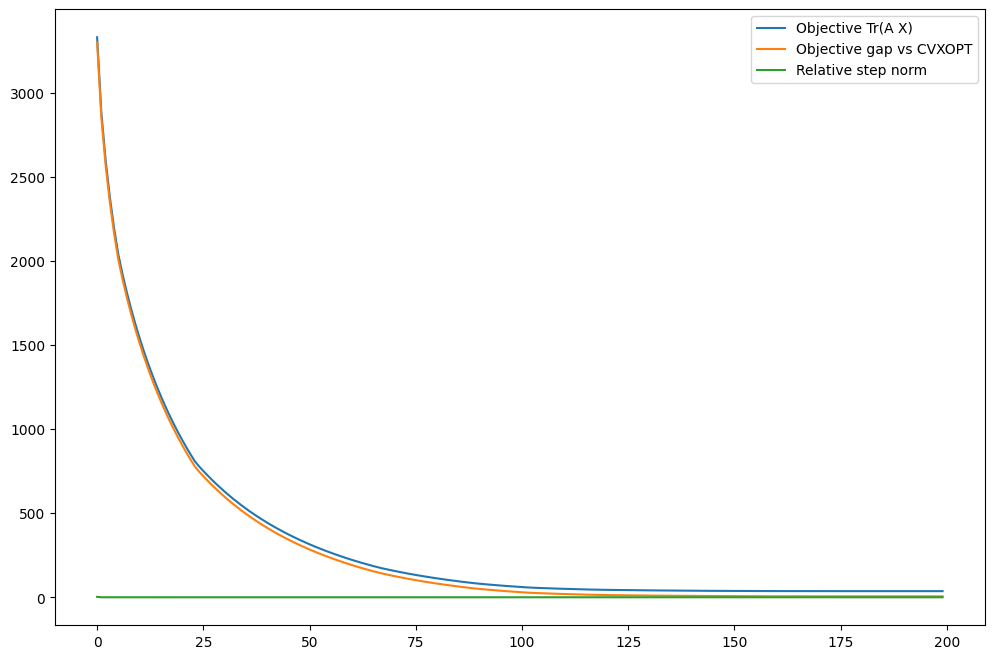

In [26]:
# Run PGD 
X_pgd, hist = projected_gradient_descent(
    A,
    f_star=prob.value,
    max_iter=200,
    alpha0=0.2,        
    proj_iters=8,      
    tol_x=1e-5,
    tol_gap=1e-2
)

# Print PGD results
print("PGD objective:", np.trace(A @ X_pgd))
print("PGD gap vs CVXOPT:", np.trace(A @ X_pgd) - prob.value)
print("diag violation:", np.max(np.abs(np.diag(X_pgd) - 1)))
print("min eigenvalue:", np.min(np.linalg.eigvalsh(0.5*(X_pgd+X_pgd.T))))
print("iterations:", len(hist["obj"]))
print("time (s):", hist["time"][-1])

# Plot convergence history
plt.figure(figsize=(12, 8))
plt.plot(hist["obj"], label="Objective Tr(A X)")
plt.plot(np.abs(hist["gap"]), label="Objective gap vs CVXOPT")
plt.plot(hist["step_norm"], label="Relative step norm")
plt.legend()